In [1]:
import logging
from utils import logging as lg

lg.set_logging()

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import math

from utils import data_provider
from notebook_utils import plot
plot.setup()

2017-10-08 01:00:16,009 | INFO : plot.py(setup 13) - Setup plot parameters


# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

2017-10-08 01:00:16,014 | INFO : data_provider.py(get_mnist 17) - Load MNIST : train
2017-10-08 01:00:16,346 | INFO : data_provider.py(get_mnist 17) - Load MNIST : test


In [4]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

2017-10-08 01:00:16,952 | INFO : plot.py(show_and_save 20) - save fig to ../figures/nb_figures/mnist-label5-with-cols.png


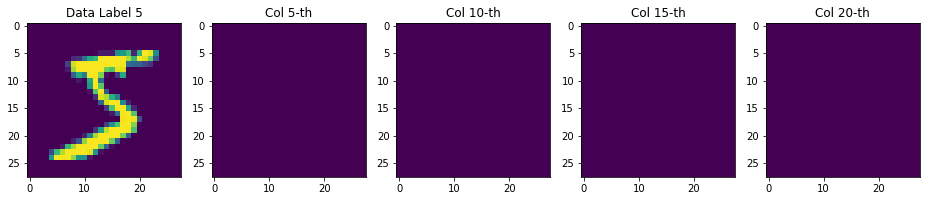

In [5]:
def plot_mnist_with_columns(data_idx, col_indices):
    plt.figure(figsize=(16,3))

    plt.subplot(1,5,1)

    plt.imshow(X_train[data_idx,:].reshape((28,28)))
    plt.title('Data Label %d' % int(np.sum(np.arange(10) * Y_train[data_idx,:])))

    count = 2
    for col_idx in col_indices:
        plt.subplot(1,5,count)
        img_zero = np.zeros((28,28))
        img_zero[:, col_idx] = X_train_2d[data_idx, :, col_idx]
        plt.title('Col %d-th' % col_idx)
        plt.imshow(img_zero, vmin=0, vmax=255)
        count = count + 1
plot_mnist_with_columns(data_idx = 0, col_indices = [5, 10,15,20])
plt.show_and_save(title='mnist-label5-with-cols.png');

In [9]:
def batch_data(x, y, n=1):
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx:min(ndx + n, l)],  y[ndx:min(ndx + n, l)])

# Training

## Network Architecture
![image.png](https://i.imgur.com/68p1mMo.png)


### Notations
- $\boldsymbol{x}^{(\alpha)}_{(\cdot,t)}$  : sample $\alpha$ with all rows of column $t \in \{1,\dots, 28\}$
- $\boldsymbol{r}^{(\alpha)}_{t}$ : recurrent inputs of column $t$ of sample $\alpha$
- $\widetilde{\boldsymbol{x}}^{(\alpha)}_{(\cdot,t)}$ : concatenation of $\boldsymbol{x}^{(\alpha)}_{(\cdot,t)}$  and $\boldsymbol{r}_{t}$
- $\boldsymbol{W}_{h}$, $\boldsymbol{b}_{h}$ : weights and bias for hidden unit activations $\boldsymbol{H}^{(\alpha)}_t$
$$
\boldsymbol{H}^{(\alpha)}_t = \text{RELU} \bigg( \widetilde{\boldsymbol{x}}^{(\alpha)}_{(\cdot,t)} \boldsymbol{W}_{h} + \boldsymbol{b}_{h}  \bigg)
$$
- $\boldsymbol{W}_{o}$, $\boldsymbol{b}_{o}$ : weights and bias for output unit activations $\boldsymbol{O}^{(\alpha)}_t$
$$
\boldsymbol{O}^{(\alpha)}_t = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{o} + \boldsymbol{b}_{o}  \bigg)
$$
- $\boldsymbol{W}_{r}$, $\boldsymbol{b}_{r}$ : weights and bias for recurrent unit activations $\boldsymbol{r}^{(\alpha)}_{t+1}$
$$
\boldsymbol{r}^{(\alpha)}_{t+1} = \text{RELU} \bigg( \boldsymbol{O}^{(\alpha)}_t \boldsymbol{W}_{r} + \boldsymbol{b}_{r}  \bigg)
$$
- $\hat{\boldsymbol{y}}^{(\alpha)}$ : class predictions of $\boldsymbol{x}^{(\alpha)}$
$$
\hat{\boldsymbol{y}}^{(\alpha)} = \text{SOFTMAX} \bigg( \boldsymbol{O}^{(\alpha)}_{28}  \bigg) 
$$

## Training Parameters

In [10]:
# These parameters are choosed arbitrarily.
NETWORK_PARAMS = {
    'batch_size': 100,
    'hidden_units': 100,
    'output_units': 10,
    'recurrent_units': 7,
    'input_dims' : 28,
    'learning_rate': 0.2,
    'train_epochs': 10
}

## Implementation

In [19]:
def train_and_evaluate():
    recurrent_inputs = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['recurrent_units']))

    input_weights = tf.Variable(
        tf.truncated_normal(
            (
             NETWORK_PARAMS['input_dims'] + NETWORK_PARAMS['recurrent_units'],
             NETWORK_PARAMS['hidden_units']
            ),
            stddev=0.1
        ),
        name="input_weights"
    )

    input_bias = tf.Variable(
        tf.zeros(
            (
             NETWORK_PARAMS['hidden_units']
            ),
        ),
        name="input_bias"
    )

    output_weights = tf.Variable(
        tf.truncated_normal(
            (NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['output_units']),
            stddev=0.1
        ),
        name="output_weights"
    )

    output_bias = tf.Variable(
        tf.zeros(
            (
             NETWORK_PARAMS['output_units']
            ),
        ),
        name="output_bias"
    )

    recurrent_output_weights = tf.Variable(
        tf.truncated_normal(
            (NETWORK_PARAMS['output_units'], NETWORK_PARAMS['recurrent_units']),
            stddev=0.1
        ),
        name="recurrent_output_weights"
    )

    recurrent_output_bias = tf.Variable(
        tf.zeros(
            (
             NETWORK_PARAMS['recurrent_units']
            ),
        ),
        name="recurrent_output_bias"
    )

    x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims'], NETWORK_PARAMS['input_dims']))
    y_ = tf.placeholder(tf.float32, [None, 10])

    rr = recurrent_inputs
    for i in range(NETWORK_PARAMS['input_dims']):
        xr = tf.concat([ x_input[:,i], rr], axis=1)
        ha = tf.nn.relu(tf.matmul(xr, input_weights) + input_bias)
        ot = tf.nn.relu(tf.matmul(ha, output_weights) + output_bias)
        rr = tf.nn.relu(tf.matmul(ot, recurrent_output_weights) + recurrent_output_bias)

    y = tf.nn.softmax(ot)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    train_step = tf.train.AdamOptimizer(0.1).minimize(cross_entropy)

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)

        for i in range(NETWORK_PARAMS['train_epochs']):
            logging.info('epoch %d' % i)
            for xf, yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
                rr = np.zeros((NETWORK_PARAMS['batch_size'], NETWORK_PARAMS['recurrent_units']))
                train_step.run(feed_dict={x_input: xf, y_: yf, recurrent_inputs: rr})

            if i % 10 == 0 or i < 10:
                correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

                rr = np.zeros((len(Y_train), NETWORK_PARAMS['recurrent_units']))

                acc = sess.run(accuracy, feed_dict={x_input: X_train_2d, y_: Y_train, recurrent_inputs: rr})
                logging.info('Training Accuracy %.2f%%' % (acc*100))
                
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        rr = np.zeros((len(Y_test), NETWORK_PARAMS['recurrent_units']))

        acc = accuracy.eval(feed_dict={x_input: X_test_2d, y_: Y_test, recurrent_inputs: rr})
        logging.info('Accuracy %.2f%%' % (acc*100))
    return acc

In [20]:
train_and_evaluate()

2017-10-08 01:04:57,594 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 79) - epoch 0
2017-10-08 01:05:03,398 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 91) - Training Accuracy 9.87%
2017-10-08 01:05:03,399 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 79) - epoch 1
2017-10-08 01:05:09,166 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 91) - Training Accuracy 9.87%
2017-10-08 01:05:09,167 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 79) - epoch 2
2017-10-08 01:05:14,992 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 91) - Training Accuracy 9.87%
2017-10-08 01:05:14,993 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 79) - epoch 3
2017-10-08 01:05:20,870 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 91) - Training Accuracy 9.87%
2017-10-08 01:05:20,871 | INFO : <ipython-input-19-df19bc4da4f5>(train_and_evaluate 79) - epoch 4
2017-10-08 01:05:26,698 | INFO : <ipython-input-19-df1

0.097999997

In [12]:
no_runs = 10
accs = []
for i in range(no_runs):
    logging.info('Run %d' % (i+1))
    acc = train_and_evaluate()
    accs.append(acc)

2017-09-24 10:49:32,386 | INFO : <ipython-input-12-38c80192bdd7>(<module> 4) - Run 1
2017-09-24 10:49:36,370 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 0
2017-09-24 10:49:43,073 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 1
2017-09-24 10:49:49,490 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 2
2017-09-24 10:49:55,782 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 3
2017-09-24 10:50:02,206 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 4
2017-09-24 10:50:08,229 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 5
2017-09-24 10:50:14,248 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 6
2017-09-24 10:50:20,423 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 7
2017-09-24 10:50:26,500 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 8
2017-09-24 10:50:32,469 | INFO : 

2017-09-24 10:57:29,154 | INFO : <ipython-input-12-38c80192bdd7>(<module> 4) - Run 8
2017-09-24 10:57:36,928 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 0
2017-09-24 10:57:42,904 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 1
2017-09-24 10:57:48,791 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 2
2017-09-24 10:57:54,729 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 3
2017-09-24 10:58:00,622 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 4
2017-09-24 10:58:06,624 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 5
2017-09-24 10:58:12,716 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 6
2017-09-24 10:58:19,004 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 7
2017-09-24 10:58:25,065 | INFO : <ipython-input-10-eb2e435aab9b>(train_and_evaluate 79) - epoch 8
2017-09-24 10:58:31,125 | INFO : 

In [15]:
print('Average accuracy over %d runs : %.2f±%.2f' % (no_runs, np.mean(accs), np.std(accs)))
print('max acc: %.2f' % np.max(accs))
print('min acc: %.2f' % np.min(accs))

Average accuracy over 10 runs : 0.17±0.09
max acc: 0.37
min acc: 0.10


# Summary
From the experiments, the maximum accuracy value found is around 0.37. However, it seems that this simple RNN network is not quite stable because it has high $\sigma$ of accuracy value.  I doubt whether it is related to the network architecture or the learning rate and learning algorithm that I choosed. 

So, I would like to explore this following points in the next step

-  do hyperparameter search
-  compute $\boldsymbol{r}_{t+1}$ from hidden unit activations rather than output unit ones.

\begin{align*}
    \boldsymbol{r}^{(\alpha)}_{t+1} = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{r} + \boldsymbol{b}_{r}  \bigg)
\end{align*}